In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

In [2]:
#loading the dataset
df_train = pd.read_csv('../input/snli-dset/snli_1.0_train.txt', sep = '\t')
df_val = pd.read_csv('../input/snli-dset/snli_1.0_dev.txt', sep = '\t')
df_test = pd.read_csv('../input/snli-dset/snli_1.0_test.txt', sep = '\t')

In [3]:
df_train['sentence1'] = df_train['sentence1'].astype(str)
df_train['sentence2'] = df_train['sentence2'].astype(str)

df_val['sentence1'] = df_val['sentence1'].astype(str)
df_val['sentence2'] = df_val['sentence2'].astype(str)

df_test['sentence1'] = df_test['sentence1'].astype(str)
df_test['sentence2'] = df_test['sentence2'].astype(str)


In [4]:
#assigning labels 
df_train['label'] = np.where(
    df_train['gold_label'] == 'contradiction', 0, np.where(
    df_train['gold_label'] == 'neutral', 1, np.where(
    df_train['gold_label'] == 'entailment',2,np.NaN))) 

df_val['label'] = np.where(
    df_val['gold_label'] == 'contradiction', 0, np.where(
    df_val['gold_label'] == 'neutral', 1, np.where(
    df_val['gold_label'] == 'entailment',2,np.NaN))) 

df_test['label'] = np.where(
    df_test['gold_label'] == 'contradiction', 0, np.where(
    df_test['gold_label'] == 'neutral', 1, np.where(
    df_test['gold_label'] == 'entailment',2,np.NaN))) 



In [5]:

df_train1 = df_train[['label','sentence1','sentence2']]
df_train1 = df_train1.dropna()

df_val1 = df_val[['label','sentence1','sentence2']]
df_val1 = df_val1.dropna()

df_test1 = df_test[['label','sentence1','sentence2']]
df_test1 = df_test1.dropna()




In [6]:
x_train_1 = df_train1['sentence1'].to_numpy()
x_train_2 = df_train1['sentence2'].to_numpy()
y_train = df_train1['label'].to_numpy().astype(int)

x_val_1 = df_val1['sentence1'].to_numpy()
x_val_2 = df_val1['sentence2'].to_numpy()
y_val = df_val1['label'].to_numpy().astype(int)

x_test_1 = df_test1['sentence1'].to_numpy()
x_test_2 = df_test1['sentence2'].to_numpy()
y_test = df_test1['label'].to_numpy().astype(int)


In [7]:
x_train_1 = x_train_1.reshape(-1,1)
x_train_2 = x_train_2.reshape(-1,1)

x_val_1 = x_val_1.reshape(-1,1)
x_val_2 = x_val_2.reshape(-1,1)

x_test_1 = x_test_1.reshape(-1,1)
x_test_2 = x_test_2.reshape(-1,1)


In [8]:
x_train_1.shape

(549367, 1)

In [9]:
x_train_concat = np.vstack((x_train_1,x_train_2,x_val_1,x_val_2))

In [10]:
x_train_concat.shape

(1118418, 1)

In [11]:
#Transforming a batch of strings (one sample = one string) into a list of token indices using TextVectorization layer.
#Applying text vectoriztion to the entire text dataset, then feeding it to a model that expects integer sequences as inputs.
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#TextVectorization layer will only consider the top 50,000 words, and will truncate or pad sequences to be actually 15 tokens long.

vectorizer = TextVectorization(max_tokens=50000, output_sequence_length=15)

#calling the vectorization layer's adapt() method on the dataset. When this layer is adapted, it analyzes the dataset, determine the frequency of individual string values, and creates a 'vocabulary' from them.

vectorizer.adapt(x_train_concat)

x_train_1 = x_train_1.reshape(-1)
x_train_2 = x_train_2.reshape(-1)

x_val_1 = x_val_1.reshape(-1)
x_val_2 = x_val_2.reshape(-1)

x_test_1 = x_test_1.reshape(-1)
x_test_2 = x_test_2.reshape(-1)

#vectorizing the dataset

x_train__1 = vectorizer(np.array([[s] for s in x_train_1 ])).numpy()
x_train__2 = vectorizer(np.array([[s] for s in x_train_2 ])).numpy()


x_val__1 = vectorizer(np.array([[s] for s in x_val_1])).numpy()
x_val__2 = vectorizer(np.array([[s] for s in x_val_2])).numpy()

x_test__1 = vectorizer(np.array([[s] for s in x_test_1])).numpy()
x_test__2 = vectorizer(np.array([[s] for s in x_test_2])).numpy()




In [12]:
#creating a dict mapping words to their indices:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [13]:
#loading pre-trained word embeddings
path_to_glove_file = '../input/snli-dset/glove.6B.100d.txt'


#creating a dict mapping words (strings) to their NumPy vector representation:
embeddings_index = {}
with open(path_to_glove_file,encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [14]:
#Preparing a corresponding embedding matrix that we can use in a Keras Embedding layer.
#The embedding matrix is a NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 27661 words (8583 misses)


In [15]:
#Loading the pre-trained word embeddings matrix into an Embedding layer.

from tensorflow.keras.layers import Embedding


#set trainable=False so as to keep the embeddings fixed during training 
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [16]:
x_train_1.shape, x_train_2.shape

((549367,), (549367,))

In [17]:
from keras import backend as K

In [1]:
#using Keras callbacks function to save the model with the best validation set accuracy
from keras.callbacks import ModelCheckpoint
filepath="NLI_model.{epoch:03d}-{val_accuracy:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only = True, mode = 'max')

In [19]:
#defining the model architecture

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    input1 = tf.keras.layers.Input(shape=(None,), dtype="int64")
    input2 = tf.keras.layers.Input(shape=(None,), dtype="int64")
    
    embedded_sequences1 = embedding_layer(input1)
    embedded_sequences2 = embedding_layer(input2)
    
    x1 = tf.keras.layers.Dense(150,activation='relu')(embedded_sequences1)
    x1 = tf.keras.layers.Dropout(0.3)(x1)
    x2 = tf.keras.layers.Dense(150,activation='relu')(embedded_sequences2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

 
    
    x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,recurrent_dropout = 0.2))(x1)
    x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150,recurrent_dropout = 0.2))(x2)   
    
 
    merge_layer = tf.keras.layers.concatenate([x1,x2])
   
    
    x = tf.keras.layers.Dense(600,activation='relu')(merge_layer)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(600,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(600,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(3,activation = 'softmax')(x)
    model = tf.keras.Model(inputs = [input1,input2], outputs = outputs)
    model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],steps_per_execution=32)

In [20]:
history = model.fit([x_train__1,x_train__2], y_train, batch_size=1024, epochs=30, validation_data=([x_val__1,x_val__2], y_val), callbacks = [checkpoint])

Epoch 1/30
537/537 [==============================] - 36s 67ms/step - loss: 1.0002 - accuracy: 0.4969 - val_loss: 0.8731 - val_accuracy: 0.6045
Epoch 2/30
537/537 [==============================] - 5s 9ms/step - loss: 0.8213 - accuracy: 0.6298 - val_loss: 0.7269 - val_accuracy: 0.6872
Epoch 3/30
537/537 [==============================] - 5s 10ms/step - loss: 0.7668 - accuracy: 0.6635 - val_loss: 0.7317 - val_accuracy: 0.6949
Epoch 4/30
537/537 [==============================] - 5s 10ms/step - loss: 0.7212 - accuracy: 0.6903 - val_loss: 0.6579 - val_accuracy: 0.7271
Epoch 5/30
537/537 [==============================] - 5s 10ms/step - loss: 0.6883 - accuracy: 0.7074 - val_loss: 0.6279 - val_accuracy: 0.7391
Epoch 6/30
537/537 [==============================] - 5s 10ms/step - loss: 0.6652 - accuracy: 0.7193 - val_loss: 0.6115 - val_accuracy: 0.7487
Epoch 7/30
537/537 [==============================] - 5s 9ms/step - loss: 0.6475 - accuracy: 0.7287 - val_loss: 0.5932 - val_accuracy: 0.7523


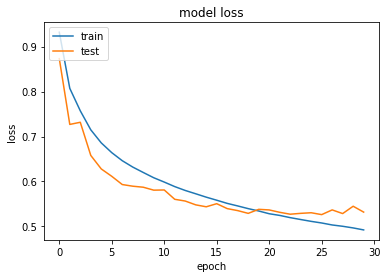

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.evaluate([x_test__1,x_test__2],y_test)

307/307 [==============================] - 4s 12ms/step - loss: 0.5376 - accuracy: 0.7890


[0.5375752449035645, 0.7889862060546875]